# FERC Electric Quarterly Report (EQR) Access Examples

### Background
The Electric Quarterly Report (EQR) is submitted by sellers participating in bilateral electricity market transactions. The reports summarize the contractual terms and conditions in agreements for all jurisdictional services, including cost-based sales, market-based rate sales, and transmission service, as well as transaction information for short-term and long-term market-based power sales and cost-based power sales.

We've known that users are interested in this dataset for some time, but have been deterred by the large size relative to other datasets in PUDL. However, with the help of modern tooling like [DuckDB](https://duckdb.org/), we've finally been able to make an initial version of the EQR dataset available in PUDL. This initial version applies some basic cleaning to the raw data, but is primarily focused on just making the data accessible. We hope to work with users going forward to identify high-priority targets for quality improvements, so please reach out if you discover any irregularities within the data!

EQR data is comprised of the following 4 tables:

- `core_ferceqr__contracts`
- `core_ferceqr__quarterly_identity`
- `core_ferceqr__quarterly_index_pub`
- `core_ferceqr__transactions`

For table and column level metadata see our [docs](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/ferceqr.html#ferc-form-920-electric-quarterly-report-eqr).

### Working with EQR
Both the size and structure of the EQR dataset makes working with this data slightly different, and in some ways more difficult than accessing other PUDL tables. All of the tables have a partitioned structure, where one table is actually comprised of a directory of parquet files (as opposed to one parquet file containing the entire table as with other PUDL tables). While this partitioned structure is new to PUDL, it is quite common with parquet data and should be handled well by typical tools. The size of the dataset, however, presents a more significant challenge. Fortunately, this is only an issue for the `core_ferceqr__transactions` table, which is >83GB in total. The other tables are all small enough that they can be loaded in their entirety into memory on almost any computer.

This notebook will demonstrate how to access EQR data using several standard Python tools, and provide some tips for working with the big transactions table without crashing your computer. The specific tools we will be using are below:

- `pandas` - go to dataframe library in Python, but not particularly well suited for working with large data
- `duckdb` - a fast, memory efficient SQL database system with a Python API

## Basic access

In [1]:
import pandas as pd

ident = pd.read_parquet("s3://pudl.catalyst.coop/ferceqr/core_ferceqr__quarterly_identity/")
ident.head()

,year_quarter,company_id_ferc,filer_unique_id,company_name,contact_name,contact_title,contact_address,contact_city,contact_state,contact_zip,contact_country_name,contact_phone,contact_email,transactions_reported_to_index_price_publishers
0,2013q3,C001621,FS1,Lakeside Syracuse LLC,Mark Hall,EVP,1200 Harger Road Suite 718,Oak Brook,Il,60523,US,312-676-0713,mhall@lakesideenergy.com,False
1,2013q3,C001621,FA1,Lakeside Syracuse LLC,Angela Gregory,Regulatory,"4700 W. Sam Houston N., #250",Houston,TX,77041,US,281-653-1039,angela.gregory@edftrading.com,False
2,2013q3,C001620,FS1,Lakeside Beaver Falls LLC,Mark Hall,EVP,1200 Harger Road Suite 718,Oak Brook,Il,60523,US,312-676-0713,mhall@lakesideenergy.com,False
3,2013q3,C001620,FA1,Lakeside Beaver Falls LLC,Angela Gregory,Regulatory,"4700 W. Sam Houston N., #250",Houston,TX,77041,US,281-653-1039,angela.gregory@edftrading.com,False
4,2013q3,C002125,FS1,"Hinson Power Company, LLC",Chun J Shin,Compliance Specialist,301 Tresser Blvd,Stamford,CT,06901,US,203-328-2426,clark.shin@glencore-us.com,False


This snippet above demonstrates how easy it is to query data from a partitioned table like these. Passing a directory to the `read_parquet` function works without any special considerations. It also gives us some insight into the data contained in the `identity` table. This table contains data specific to the individual who filed EQR on behalf of a company for a specific year-quarter. This table is probably not particularly interesting in most contexts, so let's take a look at another table.

In [2]:
contracts = pd.read_parquet("s3://pudl.catalyst.coop/ferceqr/core_ferceqr__contracts/")
contracts.head()

,year_quarter,seller_company_id_ferc,contract_unique_id,seller_company_name,customer_company_name,contract_affiliate,ferc_tariff_reference,contract_service_agreement_id,contract_execution_date,commencement_date_of_contract_term,...,rate_minimum,rate_maximum,rate_description,rate_units,point_of_receipt_balancing_authority,point_of_receipt_specific_location,point_of_delivery_balancing_authority,point_of_delivery_specific_location,begin_date,end_date
0,2013q3,C001621,C1,Lakeside Syracuse LLC,New York Independent System Operator,False,Rate Schedule No. 1,NYISO Agreement,2013-04-01,2013-04-01,...,0.0,0.0,Market Based,$/MWH,None,None,None,None,NaT,NaT
1,2013q3,C001621,C1,Lakeside Syracuse LLC,New York Independent System Operator,False,Rate Schedule No. 1,NYISO Agreement,2013-04-01,2013-04-01,...,0.0,0.0,Market Based,FLAT RATE,None,None,None,None,NaT,NaT
2,2013q3,C001621,C1,Lakeside Syracuse LLC,New York Independent System Operator,False,Rate Schedule No. 1,NYISO Agreement,2013-04-01,2013-04-01,...,0.0,0.0,Market Based,FLAT RATE,None,None,None,None,NaT,NaT
3,2013q3,C001621,C1,Lakeside Syracuse LLC,New York Independent System Operator,False,Rate Schedule No. 1,NYISO Agreement,2013-04-01,2013-04-01,...,0.0,0.0,Market Based,FLAT RATE,None,None,None,None,NaT,NaT
4,2013q3,C001621,C1,Lakeside Syracuse LLC,New York Independent System Operator,False,Rate Schedule No. 1,NYISO Agreement,2013-04-01,2013-04-01,...,0.0,0.0,Market Based,$/MWH,None,None,None,None,NaT,NaT


The `contracts` table contains information about contracts between companies selling and buying electricity market products. Unfortunately, we only have unique identifiers for the selling companies, while the purchasing companies are identified only by free-form strings. We have significant experience performing record linkage to assign unique ID's to entities like these, but we have not yet had the time or resources to devote to this problem. Despite this limitation, there's still a wealth of information contained in this table. For example, we can use this table to examine the distribution of types of products sold in a single Balancing Authority (BA) over a given time period.

<Axes: xlabel='product_type_name'>

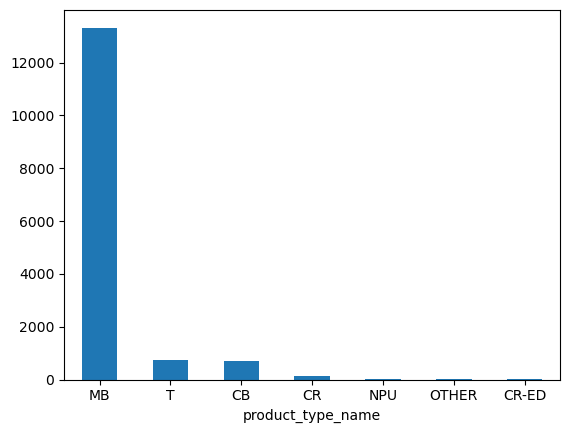

In [3]:
import datetime

ba_name = "PJM"
date_range_start = datetime.date(2017, 8, 1)
date_range_end = datetime.date(2018, 11, 1)

contracts_filtered = contracts.loc[
    (contracts["point_of_delivery_balancing_authority"] == ba_name)
    & (contracts["contract_execution_date"] >= date_range_start)
    & (contracts["contract_execution_date"] <= date_range_end)
]

contracts_filtered["product_type_name"].value_counts().plot.bar(rot=0)

It's clear that the vast majority of these contracts are classified as `MB`, and we can check the [data dictionary](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/pudl_db.html#core-ferceqr-contracts) to see the description of this code (and others):

```
MB: Energy, capacity or ancillary services sold under the seller’s FERC-approved market-based rate tariff.
```

## Accessing the BIG Transactions Table
Now that we've demonstrated access to the smaller tables, we'll dive into working with the large transactions table. This can still be done using Pandas, but we won't be able to load the entire table into memory, so we will need to add some filters to our initial query. As an example, we'll take the filters used above on the `contracts` table, but we'll need an even more restrictive date range to avoid running out of memory.

In [ ]:
date_range_end = datetime.date(2017, 9, 1)

transactions = pd.read_parquet(
    "s3://pudl.catalyst.coop/ferceqr/core_ferceqr__transactions/",
    filters=[
        ("trade_date", ">=", date_range_start),
        ("trade_date", "<=", date_range_end),
        ("point_of_delivery_balancing_authority", "=", ba_name)
    ],
)
transactions.head()

This works just fine if you only need to work with a small portion of the table at a time, but will quickly run up against memory limitations if you ever need to access a larger chunk of the table. This is where tools like `DuckDB` and [Polars](https://docs.pola.rs/) come in. For this tutorial we'll focus on `DuckDB` for simplicity, and because we've been particularly impressed with `DuckDB's` performance. We can recreate the query above with the following snippet:

In [4]:
import duckdb

(
    duckdb.read_parquet("s3://pudl.catalyst.coop/ferceqr/core_ferceqr__transactions/*.parquet")
    .filter(f"trade_date BETWEEN DATE '{date_range_start}' AND DATE '{date_range_end}'")
    .filter(f"point_of_delivery_balancing_authority = '{ba_name}'")
    .limit(5)
    .fetchdf()
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,year_quarter,seller_company_id_ferc,transaction_unique_id,seller_company_name,customer_company_name,ferc_tariff_reference,contract_service_agreement_id,seller_transaction_id,transaction_begin_date,transaction_end_date,...,product_name,rate_units,point_of_delivery_balancing_authority,point_of_delivery_specific_location,transaction_quantity,price,standardized_quantity,standardized_price,total_transmission_charge,total_transaction_charge
0,2017q2,C001276,T1373,"GenOn Energy Management, LLC","PJM Settlement, Inc.","Reactive Rate Schedule,FERC Electric Tariff,Or...",PJM_GEM_REMA Reactive 2.3,T29714RRIQ2,2017-06-01,2017-06-30 23:59:00,...,REACTIVE SUPPLY & VOLTAGE CONTROL,FLAT RATE,PJM,PJM REMA,1.000,191666.660000,NaN,NaN,0.0,191666.70
1,2017q2,C001276,T2546,"GenOn Energy Management, LLC","PJM Settlement, Inc.","Reactive Rate Schedule,FERC Electric Tariff,Or...",PJM_GEM_REMA Reactive 2.3,T29698RRIQ2,2017-05-30,2017-05-31 23:59:00,...,REACTIVE SUPPLY & VOLTAGE CONTROL,FLAT RATE,PJM,PJM REMA,1.000,12365.590000,NaN,NaN,0.0,12365.59
2,2017q2,C000202,T441396411,"Exelon Generation Company, LLC",DELMARVA POWER AND LIGHT COMPANY,"FERC Electric Tariff, Market-Based Rate Tariff...",DT30882,PYP4LG3,2017-05-01,2017-06-01 00:00:00,...,REQUIREMENTS SERVICE,$/MWH,PJM,DPL - DE,2641.890,78.814951,NaN,NaN,0.0,208220.43
3,2017q2,C000202,T441396412,"Exelon Generation Company, LLC",DELMARVA POWER AND LIGHT COMPANY,"FERC Electric Tariff, Market-Based Rate Tariff...",DT30882,PYS4NOY,2017-06-01,2017-07-01 00:00:00,...,REQUIREMENTS SERVICE,$/MWH,PJM,DPL - DE,203.201,-4.358000,NaN,NaN,0.0,-885.55
4,2017q2,C000202,T441425092,"Exelon Generation Company, LLC",POTOMAC ELECTRIC POWER COMPANY,"FERC Electric Tariff, Market-Based Rate Tariff...",PEPCO.Master.2017,PYS4LFX,2017-05-01,2017-06-01 00:00:00,...,REQUIREMENTS SERVICE,$/MWH,PJM,PEPCO DC,-1942.183,70.257556,NaN,NaN,0.0,-136453.03


`DuckDB` is even capable of operating on the entire table using its streaming SQL engine to avoid ever loading the full table into memory.

As an example, we'll examine the distribution of values in the column `class_name`, which identifies transactions as firm (F), non-firm (NF), or unit power sale (UP).

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<Axes: xlabel='class_name'>

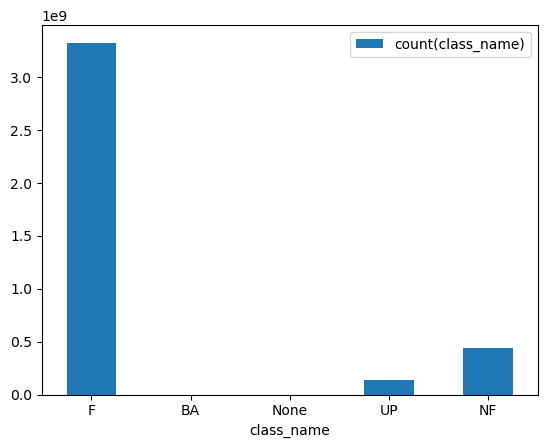

In [5]:
(
    duckdb.read_parquet("s3://pudl.catalyst.coop/ferceqr/core_ferceqr__transactions/*.parquet")
    .value_counts(column="class_name", groups="class_name")
    .fetchdf()
    .set_index("class_name")
    .plot.bar(rot=0)
)